# Benchmarking of two pass method:

In this notebook we will plot the figures showing the benchmarking analyses for the two pass method compared to one pass as a negative control, and reference guided alignment as a positive control. The data here is only for simulated Arabidopsis and human reads

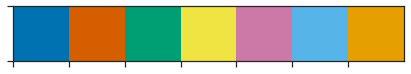

In [1]:
import sys
import re
from collections import Counter
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import display_markdown, display

## Default plotting params

np.random.seed(101)

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
USESAMPLES = [
    'firstpass', 'nofilt', 'dt1filt', 'dt2filt', 'flair_corrected', 'refguided'
]

def read_splice_assignments(tsv_fn):
    res = Counter()
    with open(tsv_fn) as f:
        for line in f:
            read_id, classi = line.split()
            res[classi] += 1
    return res


def get_sim_dataset_splice_assignments(basedir, usesamples=USESAMPLES):
    res = []
    for fn in glob(f'../pipeline/{basedir}/*/metrics/*.sim_nofrag.*.tsv'):
        if 'quant' in fn:
            continue
        sample_name, sample_type = re.search('metrics/(.+?)\.sim_nofrag\.(.+?)\.tsv$', fn).groups()
        if not sample_type in usesamples:
            continue
        r = read_splice_assignments(fn)
        res.append([sample_name, sample_type,
                    r['spliced_correctly'],
                    r['spliced_incorrectly_annot'],
                    r['unspliced_incorrectly'] + r['spliced_incorrectly_unannot']])

    res = pd.DataFrame(
        res,
        columns=['dataset', 'method',
                 'correct_annot', 'incorrect_annot', 'incorrect_unannot']
    )
    res_melt = pd.melt(
        res,
        id_vars=['dataset', 'method'],
        value_vars=['correct_annot', 'incorrect_annot', 'incorrect_unannot'],
        var_name='aln_cat',
        value_name='freq'
    )
    res_melt = (res_melt.groupby(['dataset', 'method'], as_index=False)
                        .apply(lambda x: x.assign(norm_freq=x.freq / sum(x.freq) * 100))
                        .reset_index(drop=True))
    return res_melt


def get_sim_dataset_quant_res(basename, usesamples=USESAMPLES, is_ensembl=False):
    quant_res = []
    for gt_fn in glob(f'../pipeline/{basename}/*/simulated_data/*_quant.tsv'):
        gt_counts = pd.read_csv(
            gt_fn,
            sep='\t',
            names=['transcript_id', 'gt_count']
        )
        if is_ensembl:
            gt_counts.transcript_id = gt_counts.transcript_id.str.split('.', expand=True)[0]
        sample_name = re.search(f'{basename}/(.+?)/simulated_data', gt_fn).group(1)
        for fn in glob(f'../pipeline/{basename}/{sample_name}/metrics/*.sim_nofrag.*.quant.tsv'):
            sample_type = re.search('sim_nofrag\.(.+?)\.quant\.tsv$', fn).group(1)
            counts = pd.read_csv(fn, sep='\t', names=['transcript_id', 'pred_count'])
            counts = gt_counts.merge(counts, on='transcript_id', how='left').fillna(0)
            pearsonr = stats.pearsonr(counts.gt_count, counts.pred_count)[0]
            spearmanr = stats.spearmanr(counts.gt_count, counts.pred_count)[0]
            quant_res.append([sample_name, sample_type, pearsonr, spearmanr])
    quant_res = pd.DataFrame(
        quant_res,
        columns=['dataset', 'method', 'pearsonr', 'spearmanr']
    )
    return quant_res

In [3]:
arath_aln_stats = get_sim_dataset_splice_assignments('arabidopsis_drs')
human_aln_stats = get_sim_dataset_splice_assignments('human_drs')

arath_quant_res = get_sim_dataset_quant_res('arabidopsis_drs')
human_quant_res = get_sim_dataset_quant_res('human_drs', is_ensembl=True)

In [4]:
arath_aln_stats

,dataset,method,aln_cat,freq,norm_freq
0,201901_col0_2916,dt1filt,correct_annot,717762,87.935274
1,201901_col0_2916,dt1filt,incorrect_annot,20479,2.508947
2,201901_col0_2916,dt1filt,incorrect_unannot,77998,9.555780
3,201901_col0_2916,dt2filt,correct_annot,727557,89.135290
4,201901_col0_2916,dt2filt,incorrect_annot,22097,2.707173
...,...,...,...,...,...
67,201901_col0_2919,nofilt,incorrect_annot,11369,1.811914
68,201901_col0_2919,nofilt,incorrect_unannot,137778,21.958123
69,201901_col0_2919,refguided,correct_annot,588536,93.796876
70,201901_col0_2919,refguided,incorrect_annot,16277,2.594118


In [5]:
DEFAULT_BOXPLOT_KWARGS = {'color': '#eeeeee', 'fliersize': 0, 'width': 0.8}
DEFAULT_STRIPPLOT_KWARGS = {'jitter': 0.2, 'color': pal[0], 'size': 8, 'dodge': True}


def boxplot_with_overlaid_stripplot(*, x, y, hue=None, data=None,
                                    order=None, strip_hue=None,
                                    boxplot_kwargs=None,
                                    stripplot_kwargs=None,
                                    ax=None):
    if boxplot_kwargs is None:
        boxplot_kwargs = DEFAULT_BOXPLOT_KWARGS
    else:
        boxplot_kwargs = dict(DEFAULT_BOXPLOT_KWARGS, **boxplot_kwargs)

    if stripplot_kwargs is None:
        stripplot_kwargs = DEFAULT_STRIPPLOT_KWARGS
    else:
        stripplot_kwargs = dict(DEFAULT_STRIPPLOT_KWARGS, **stripplot_kwargs)

    ax = sns.boxplot(
        x=x,
        y=y,
        data=data,
        hue=hue,
        order=order,
        ax=ax,
        **boxplot_kwargs
    )

    ax = sns.stripplot(
        x=x,
        y=y,
        data=data,
        hue=strip_hue if strip_hue is not None else hue,
        order=order,
        ax=ax,
        **stripplot_kwargs
    )

    return ax


def plot_correctly_aligned_reads_arath_human(order, labels):
    fig, axes = plt.subplots(figsize=(12, 5.5), ncols=2, sharey=True)
    boxplot_with_overlaid_stripplot(
        x='method',
        y='norm_freq',
        data=arath_aln_stats.query('aln_cat == "correct_annot"'),
        ax=axes[0],
        order=order
    )

    boxplot_with_overlaid_stripplot(
        x='method',
        y='norm_freq',
        data=human_aln_stats.query('aln_cat == "correct_annot"'),
        ax=axes[1],
        order=order
    )

    axes[0].set_xlabel('Alignment strategy')
    axes[1].set_xlabel('Alignment strategy')
    axes[0].set_ylabel('Correctly aligned\nspliced reads (%)')
    axes[1].set_ylabel('')
    axes[0].set_xticklabels(labels)
    axes[1].set_xticklabels(labels)
    for i in range(len(labels) - 1):
        axes[0].axvline(i + 0.5, ls='--', color='#555555')
        axes[1].axvline(i + 0.5, ls='--', color='#555555')
    axes[0].set_xlim(-0.5, len(labels) - 0.5)
    axes[1].set_xlim(-0.5, len(labels) - 0.5)
    axes[0].set_title('Arabidopsis\n(TAIR10 + AtRTD2 reference)')
    axes[1].set_title('Human (GRCh38 reference)')
    plt.tight_layout()
    return axes


def plot_incorrectly_aligned_reads_arath_human(order, labels):
    fig, axes = plt.subplots(figsize=(12, 5.5), ncols=2, sharey=True)

    boxplot_with_overlaid_stripplot(
        x='method',
        y='norm_freq',
        hue='aln_cat',
        data=arath_aln_stats.query('aln_cat != "correct_annot"'),
        ax=axes[0],
        order=order,
        stripplot_kwargs={'color': None, 'palette': pal[1:]}
    )

    boxplot_with_overlaid_stripplot(
        x='method',
        y='norm_freq',
        hue='aln_cat',
        data=human_aln_stats.query('aln_cat != "correct_annot"'),
        ax=axes[1],
        order=order,
        stripplot_kwargs={'color': None, 'palette': pal[1:]}
    )

    axes[0].set_xlabel('Alignment strategy')
    axes[1].set_xlabel('Alignment strategy')
    axes[0].set_ylabel('Incorrectly aligned\nspliced reads (%)')
    axes[1].set_ylabel('')
    axes[0].set_xticklabels(labels)
    axes[1].set_xticklabels(labels)

    for i in range(len(labels) - 1):
        axes[0].axvline(i + 0.5, ls='--', color='#555555')
        axes[1].axvline(i + 0.5, ls='--', color='#555555')

    axes[0].set_title('Arabidopsis\n(TAIR10 + AtRTD2 reference)')
    axes[1].set_title('Human (GRCh38 reference)')


    axes[0].legend_.remove()
    axes[1].legend_.remove()
    axes[0].set_xlim(-0.5, len(labels) - 0.5)
    axes[1].set_xlim(-0.5, len(labels) - 0.5)

    dh1 = axes[0].scatter([], [], color=pal[1], s=35)
    dh2 = axes[0].scatter([], [], color=pal[2], s=35)

    axes[1].legend_ = plt.legend([dh1, dh2], ['Not in annot.', 'Incorrect annot.\ntranscipt'])

    plt.tight_layout()
    return axes

### FLAIR correction vs. minimap2 reference guided alignment:

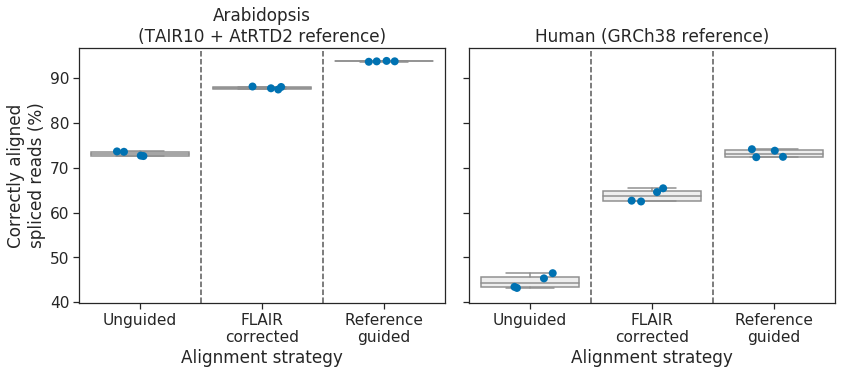

In [6]:
plot_correctly_aligned_reads_arath_human(
    ['firstpass', 'flair_corrected', 'refguided'],
    ['Unguided', 'FLAIR\ncorrected', 'Reference\nguided'],
)
plt.savefig('figures/correct_percentage_flair.svg')
plt.show()

Basically this shows that it is better to do reference guided alignment than post-alignment correction to the reference, if you do have a reference to use. My expectation would be that this also holds true for using Illumina reads to produce high confidence junctions.

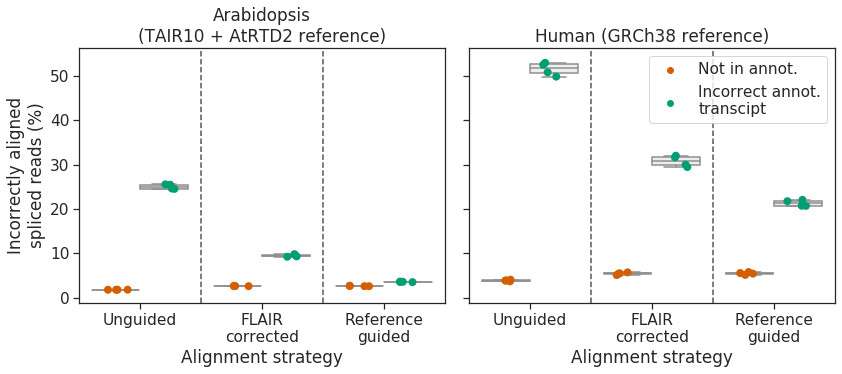

In [7]:
plot_incorrectly_aligned_reads_arath_human(
    ['firstpass', 'flair_corrected', 'refguided'],
    ['Unguided', 'FLAIR\ncorrected', 'Reference\nguided'],
)
plt.savefig('figures/incorrect_percentage_flair.svg')
plt.show()

Interestingly there is a slight increase in the number of reads which align to the wrong reference transcript when you provide the reference annotation as a guide (or do post-alignment correction with FLAIR). This may affect the transcript level quantification of some genes.

### Two pass alignment - no filtering of junctions:

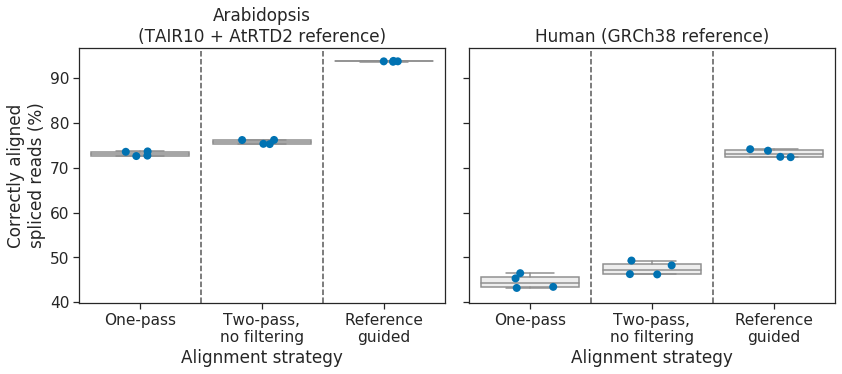

In [8]:
plot_correctly_aligned_reads_arath_human(
    ['firstpass', 'nofilt', 'refguided'],
    ['One-pass', 'Two-pass,\nno filtering', 'Reference\nguided'],
)
plt.savefig('figures/correct_percentage_naive_2pass.svg')
plt.show()

We see a very slight improvement in correctly aligned reads with a naive two pass method.

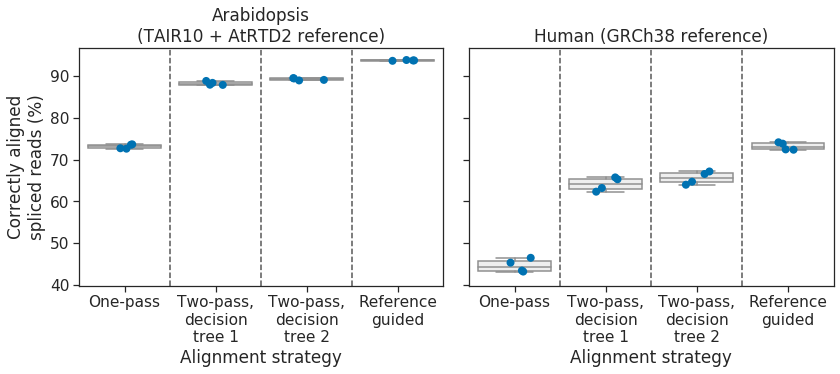

In [9]:
plot_correctly_aligned_reads_arath_human(
    ['firstpass', 'dt1filt', 'dt2filt', 'refguided'],
    ['One-pass', 'Two-pass,\ndecision\ntree 1', 'Two-pass,\ndecision\ntree 2', 'Reference\nguided'],
)
plt.savefig('figures/correct_percentage_filtered_2pass.svg')
plt.show()

Using a filtered two pass method, we can improve the alignment of nanopore DRS reads greatly. For the simulated datasets, two pass actually outperforms FLAIR despite FLAIR correcting the data using the reference!

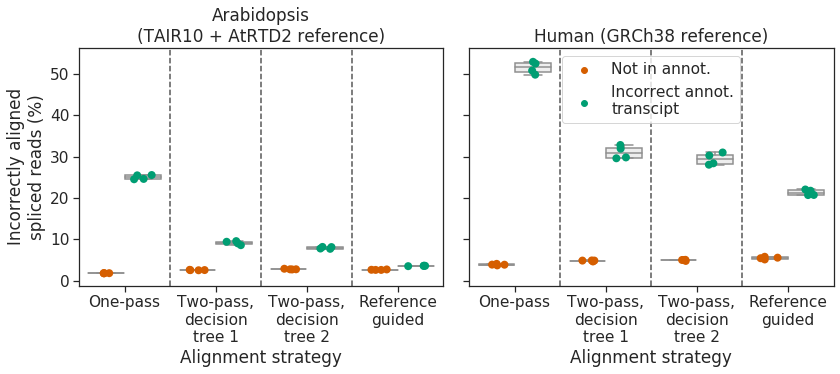

In [10]:
plot_incorrectly_aligned_reads_arath_human(
    ['firstpass', 'dt1filt', 'dt2filt', 'refguided'],
    ['One-pass', 'Two-pass,\ndecision\ntree 1', 'Two-pass,\ndecision\ntree 2', 'Reference\nguided'],
)
plt.savefig('figures/incorrect_percentage_filtered_2pass.svg')
plt.show()

A downside of the two pass method is that we do see an increase in the number of reads mapping to the incorrect reference transcript, which may affect the quantification of these transcripts.

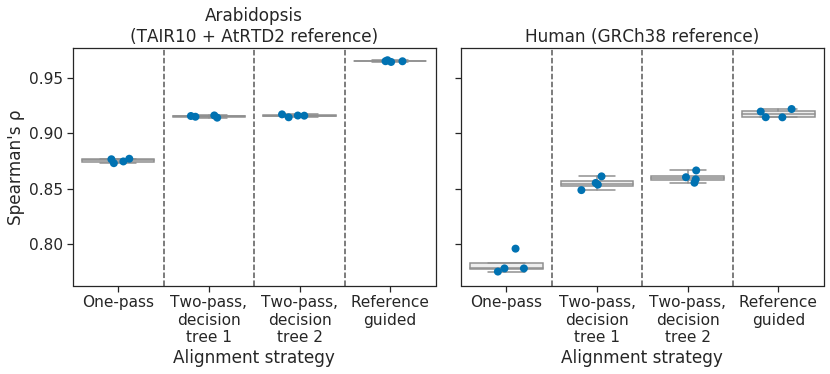

In [11]:
fig, axes = plt.subplots(figsize=(12, 5.5), ncols=2, sharey=True)

boxplot_with_overlaid_stripplot(
    x='method',
    y='spearmanr',
    data=arath_quant_res,
    ax=axes[0],
    order=['firstpass', 'dt1filt', 'dt2filt', 'refguided'],
)

boxplot_with_overlaid_stripplot(
    x='method',
    y='spearmanr',
    data=human_quant_res,
    ax=axes[1],
    order=['firstpass', 'dt1filt', 'dt2filt', 'refguided'],
)


axes[0].set_xlabel('Alignment strategy')
axes[1].set_xlabel('Alignment strategy')
axes[0].set_ylabel('Spearman\'s ρ')
axes[1].set_ylabel('')
axes[0].set_xticklabels(
    ['One-pass', 'Two-pass,\ndecision\ntree 1', 'Two-pass,\ndecision\ntree 2', 'Reference\nguided'],
)
axes[1].set_xticklabels(
    ['One-pass', 'Two-pass,\ndecision\ntree 1', 'Two-pass,\ndecision\ntree 2', 'Reference\nguided'],
)
axes[0].set_title('Arabidopsis\n(TAIR10 + AtRTD2 reference)')
axes[1].set_title('Human (GRCh38 reference)')
for i in range(3):
    axes[0].axvline(i + 0.5, ls='--', color='#555555')
    axes[1].axvline(i + 0.5, ls='--', color='#555555')
axes[0].set_xlim(-0.5, 3.5)
axes[1].set_xlim(-0.5, 3.5)
plt.tight_layout()
plt.savefig('figures/quantification_spearmanr_filtered_2pass.svg')
plt.show()

In [12]:
arath_quant_res[arath_quant_res.method.isin(['firstpass', 'dt1filt', 'dt2filt', 'refguided'])].groupby('method').spearmanr.median()

method
dt1filt      0.915172
dt2filt      0.915861
firstpass    0.875569
refguided    0.964818
Name: spearmanr, dtype: float64

In [13]:
human_quant_res[human_quant_res.method.isin(['firstpass', 'dt1filt', 'dt2filt', 'refguided'])].groupby('method').spearmanr.median()

method
dt1filt      0.854438
dt2filt      0.859417
firstpass    0.778261
refguided    0.916948
Name: spearmanr, dtype: float64

Despite this we see that the correlation of simulated counts and the counts retrieved by alignment are improved after two pass alignment, suggesting that overall this misalignment has a small effect.

### Overall statistics:

In [14]:
def display_median(dataset, aln_cat, label):
    df = pd.DataFrame(dataset.query(f'aln_cat == "{aln_cat}"').groupby('method').norm_freq.median())
    display_markdown(f'#### {label}:\n', raw=True)
    display(df)

display_median(arath_aln_stats, 'correct_annot', 'Median correct Arabidopsis')
display_median(human_aln_stats, 'correct_annot', 'Median correct human')
display_median(yeast_aln_stats, 'correct_annot', 'Median correct yeast')
display_median(arath_aln_stats, 'incorrect_annot', 'Median incorrect annot. transcript Arabidopsis')
display_median(human_aln_stats, 'incorrect_annot', 'Median incorrect annot. transcript human')
display_median(yeast_aln_stats, 'incorrect_annot', 'Median incorrect annot. transcript yeast')

#### Median correct Arabidopsis:


,norm_freq
method,
dt1filt,88.202325
dt2filt,89.307988
firstpass,73.174781
flair_corrected,87.930965
nofilt,75.806333
refguided,93.800632


#### Median correct human:


,norm_freq
method,
dt1filt,64.273897
dt2filt,65.661859
firstpass,44.391247
flair_corrected,63.643824
nofilt,47.267585
refguided,73.164109


NameError: name 'yeast_aln_stats' is not defined